In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import warnings

warnings.filterwarnings("ignore")

# Define the model

In [6]:
# Define the ResNet-based CAPTCHA model (same architecture used during training)
class ResNetCaptchaModel(nn.Module):
    def __init__(self, num_classes_per_char, num_chars):
        super(ResNetCaptchaModel, self).__init__()
        self.resnet = models.resnet50(pretrained=False)  # Used pretrained=True during training
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes_per_char * num_chars)
        self.num_classes_per_char = num_classes_per_char
        self.num_chars = num_chars

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(-1, self.num_chars, self.num_classes_per_char)  # Reshape output
        return x

# Initialize the model (same as during training)
num_classes_per_char = 36  # 10 digits + 26 letters
num_chars = 5  # Assuming CAPTCHA length is 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNetCaptchaModel(num_classes_per_char, num_chars).to(device)

# Load the weights (use map_location if on CPU)
model_path = "../input/captcha_resnet/pytorch/default/1/captcha_resnet50.pth"
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint)

# Make sure to set the model to evaluation mode
model.eval()

# Example prediction on a single image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
model

# Implement PGD attack

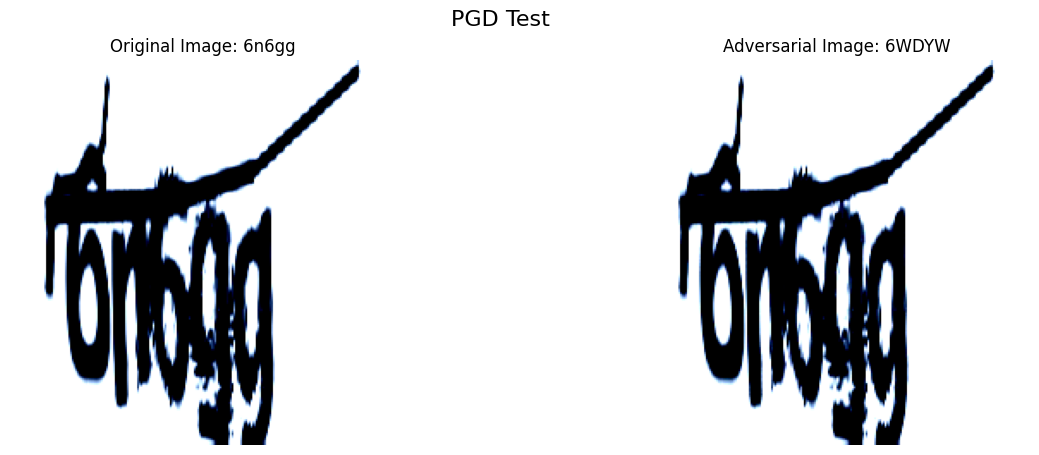

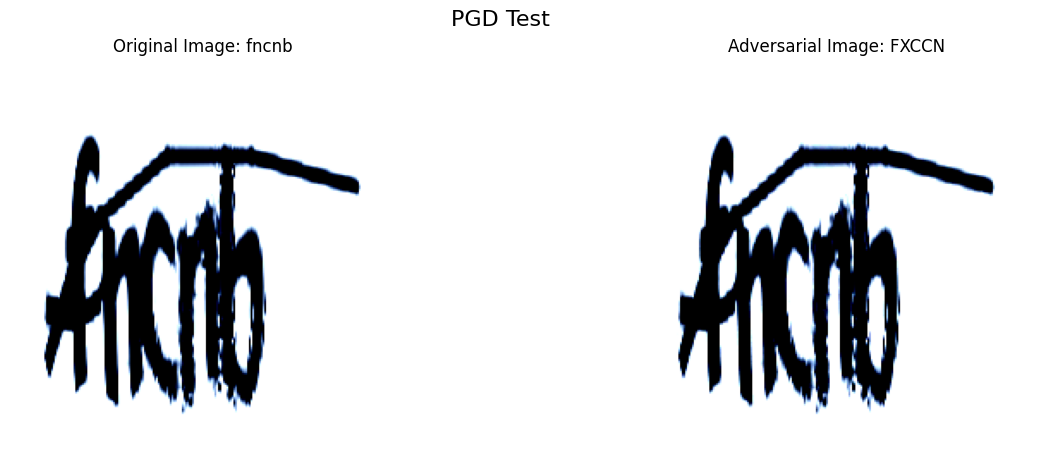

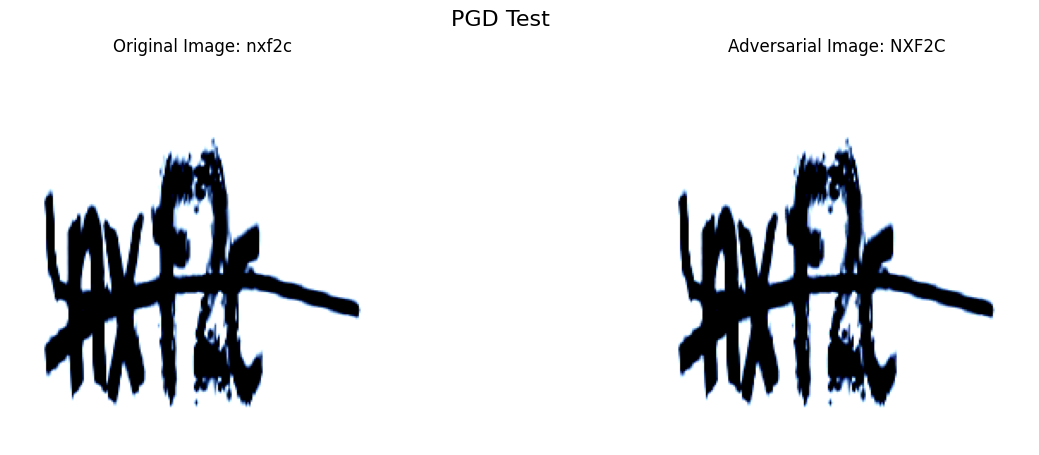

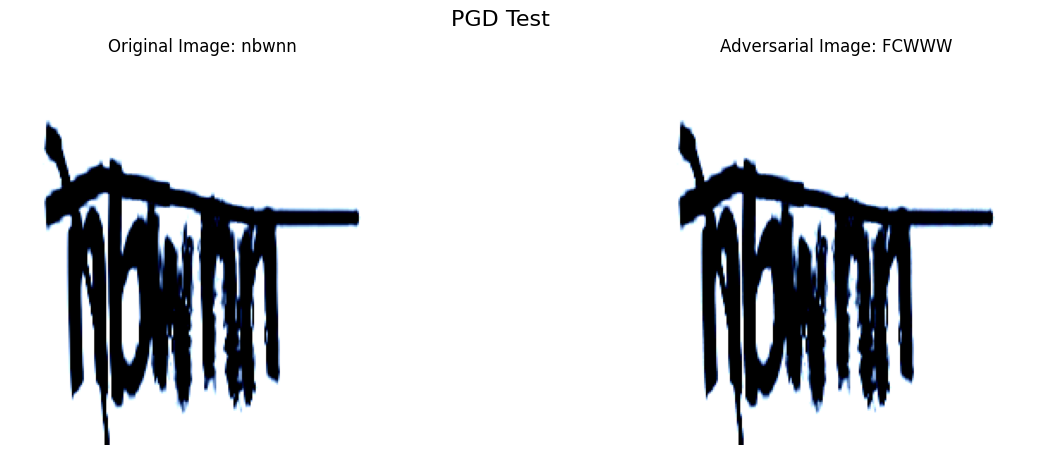

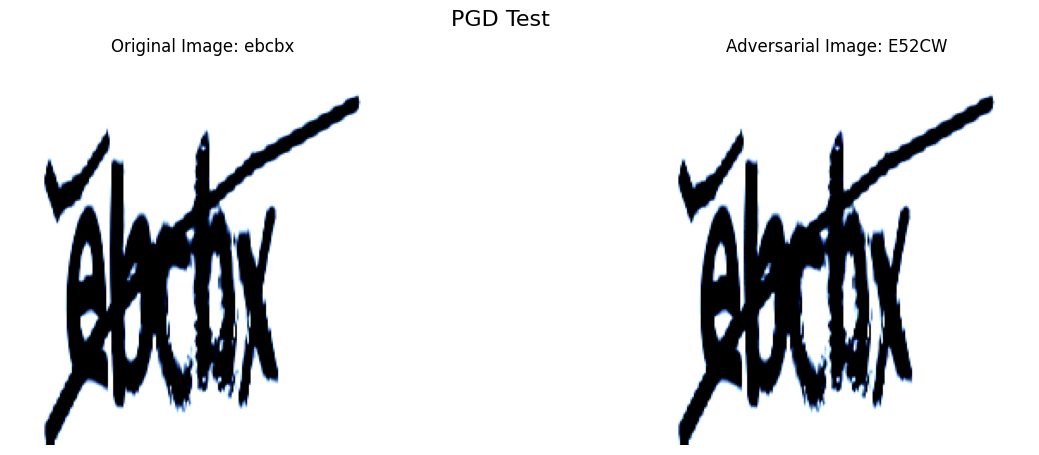

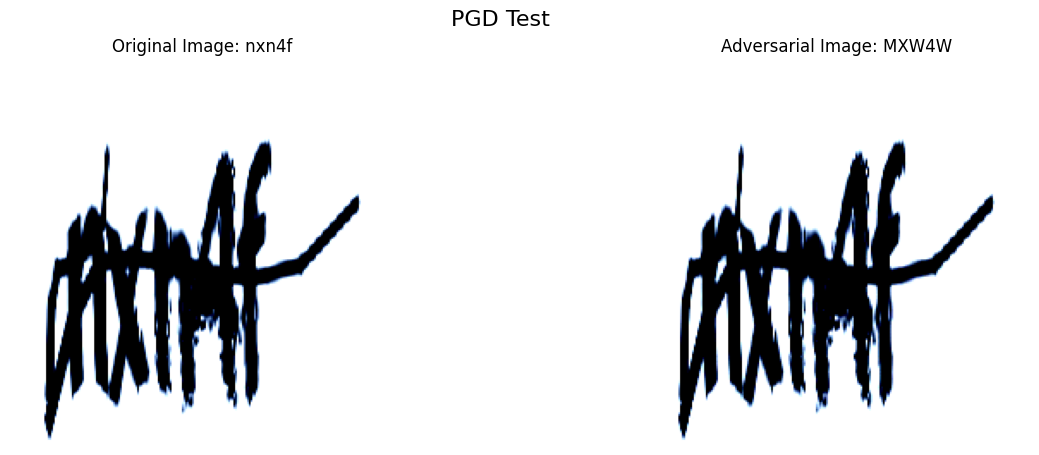

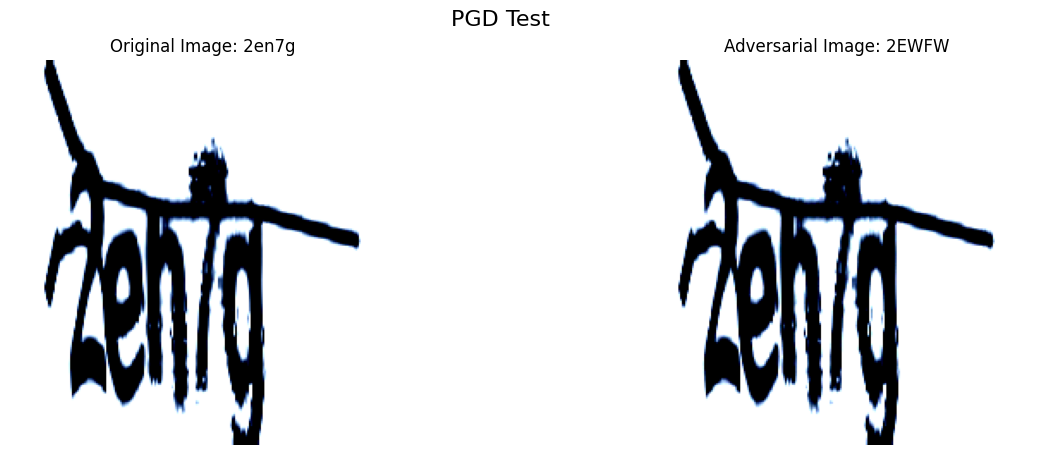

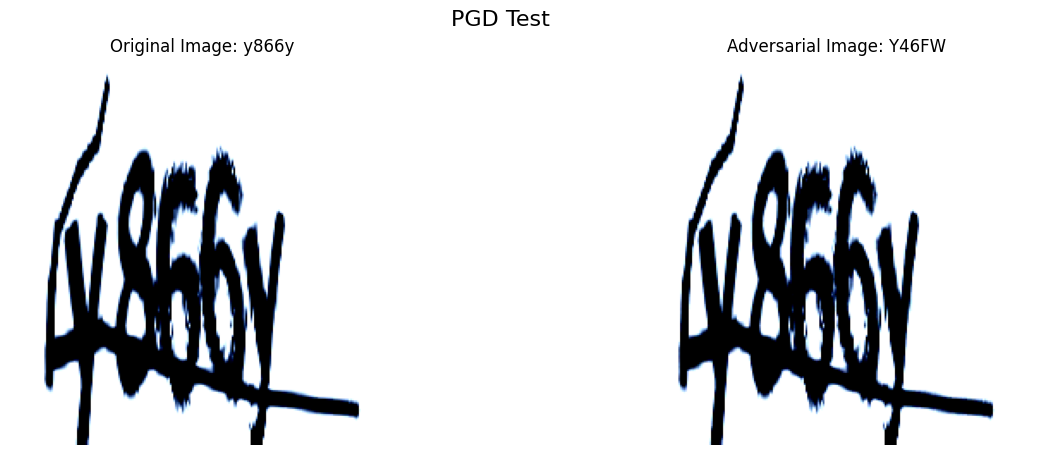

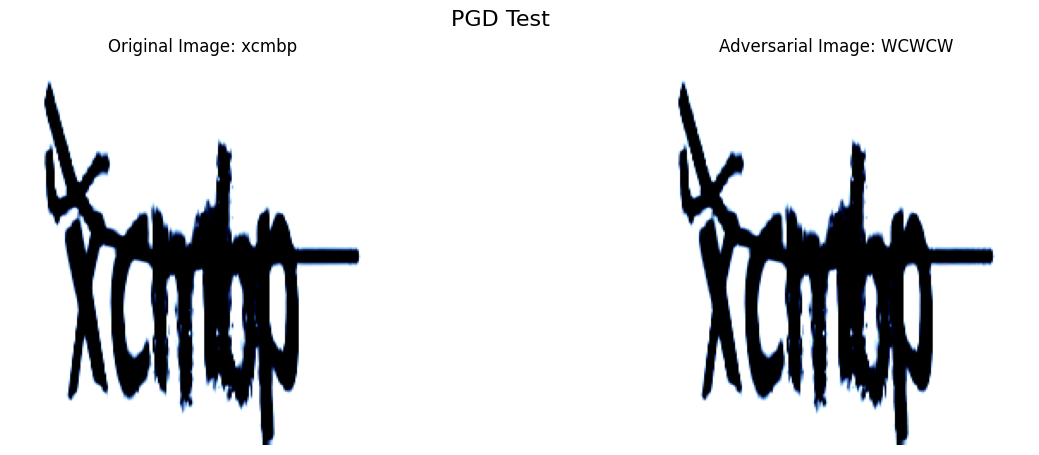

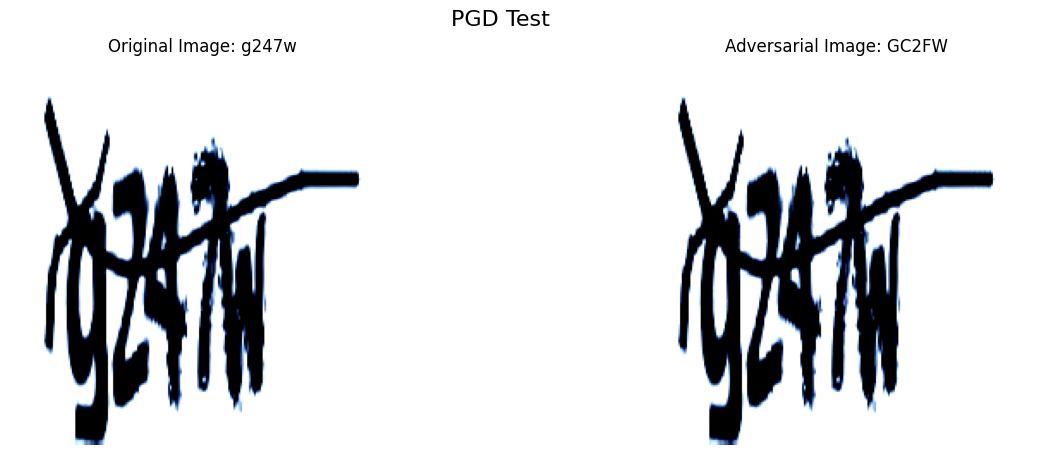

In [7]:
# Define the PGD attack
def pgd_attack(model, images, labels, eps, alpha, iters):
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    original_images = images.clone().detach()

    # Set the images to require gradients
    images.requires_grad = True
    
    for i in range(iters):
        outputs = model(images)
        loss = nn.CrossEntropyLoss()(outputs.view(-1, num_classes_per_char), labels.view(-1))
        
        model.zero_grad()
        loss.backward()
        
        # Update the images based on gradient information
        images = images + alpha * images.grad.sign()
        
        # Clamp images to maintain within eps bounds and normalize
        eta = torch.clamp(images - original_images, min=-eps, max=eps)
        images = torch.clamp(original_images + eta, min=0, max=1).detach_()
        
        images.requires_grad = True
    
    return images

# Transformations for images (same as in your training pipeline)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# PGD attack parameters
eps = 0.03  # Maximum perturbation (epsilon)
alpha = 0.01  # Step size (alpha)
iters = 40  # Number of iterations

import matplotlib.pyplot as plt

# Update the function to return the original image for comparison
def predict_and_attack_captcha(image_path, model, device, transform, eps, alpha, iters):
    # Load and transform the image
    image = Image.open(image_path).convert('RGB')
    original_image = transform(image).unsqueeze(0).to(device)
    
    # Perform PGD attack
    labels = torch.randint(0, num_classes_per_char, (1, num_chars)).to(device)  # Dummy labels for loss computation
    adv_image = pgd_attack(model, original_image, labels, eps, alpha, iters)

    # Predict on the adversarially perturbed image
    with torch.no_grad():
        outputs = model(adv_image)
    
    predicted_chars = []
    for i in range(num_chars):
        _, predicted = torch.max(outputs[:, i, :], 1)
        predicted_chars.append(predicted.item())

    # Convert indices back to characters
    captcha_text = ''.join([chr(c + ord('0')) if c < 10 else chr(c - 10 + ord('A')) for c in predicted_chars])
    
    return captcha_text, adv_image, original_image  # Return both adversarial and original images

# Define the CAPTCHA directory and iterate through images
captcha_img_dir = "../input/captcha-version-2-images/samples"
image_filenames = [f for f in os.listdir(captcha_img_dir) if f.endswith(".png") or f.endswith(".jpg")]

# Process and display for the first N images
num_display = 10
for idx, img_file in enumerate(image_filenames[:num_display]):
    img_path = os.path.join(captcha_img_dir, img_file)
    predicted_text, adv_image, original_image = predict_and_attack_captcha(img_path, model, device, transform, eps, alpha, iters)
    
    # Move images back to CPU for plotting, and detach from computation graph
    adv_image = adv_image.detach().squeeze(0).cpu().permute(1, 2, 0).numpy()  # Detach, remove batch dim, transpose for plotting
    original_image = original_image.detach().squeeze(0).cpu().permute(1, 2, 0).numpy()

    # Plot original and adversarial images side by side
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].imshow(original_image)
    axes[0].set_title(f"Original Image: {img_file.split('.')[0]}")
    axes[0].axis('off')

    axes[1].imshow(adv_image)
    axes[1].set_title(f"Adversarial Image: {predicted_text}")
    axes[1].axis('off')
    fig.suptitle("PGD Test", fontsize=16)

    plt.show()
